In [1]:
"""
Companion notebook to compare_models.py.
Read saved summaries for a set of models, see the variation in parameters while varying fairness across models.
"""
import numpy as np
import os
import pickle
import pandas as pd

def gini_fn(x):
    #calculates the gini index of distribution x
    num = 0
    for i in x:
        for j in x:
            num+=abs(i-j)
    n = len(x)
    avg = sum(x)/n
    den=(2*n*n*avg)
    gini = num/den
    return gini, avg

In [2]:
cap = 4
vehs =1000
start=0
end=24
# tag = 'Test/ModelComparison'
tag = 'Test/ModelComparison_1discount'
logdir = f"../../logs/{vehs}veh_{cap}cap_ny{start}-{end}"

#Load data
big_data = {}
keys = set()
value_funcs_set = set()

def my_listdir(folder):
    #Filter out .DS_store files
    # return [f for f in os.listdir(folder) if not f=='.DS_Store']
    dirs = [f for f in os.listdir(folder) if os.path.isdir(os.path.join(folder, f))]
    dirs.sort()
    return dirs
    

models = my_listdir(logdir+tag)
df = pd.DataFrame()

#Iteratively explore the 
for model in models:
    folder = logdir+tag+'/'+model
    alphas = my_listdir(folder)
    for alpha in alphas:
        # a = float(alpha[5:])
        folder_a = folder+'/'+alpha
        betas = my_listdir(folder_a)
        for beta in betas:
            # beta = float(beta[5:])
            folder_b = folder_a+'/'+beta+'/'
            value_funcs = my_listdir(folder_b)
            for value_function in value_funcs:
                value_funcs_set.add(value_function)
                filepath = folder_b + '/' + value_function + '/summary.pkl'
                if not os.path.isfile(filepath):
                    print(f'No Summary Found for {filepath}')
                    continue
                s = pickle.load(open(filepath,'rb'))
                if 'Source SR gini' not in s:
                    s_sr = np.array(list(s['Source SR'].values()))
                    s['Source SR gini'] = gini_fn(s_sr[:,0])
                row = {'model':model, 'alpha':float(alpha[5:]), 'beta':float(beta[4:]), 'ValueFunction':value_function}
                for k,v in s.items():
                    row[k]=v
                df = df.append(row, ignore_index=True)
# print(df)
df['Day']= df['model'].apply(lambda x: int(str(x)[-1:]))

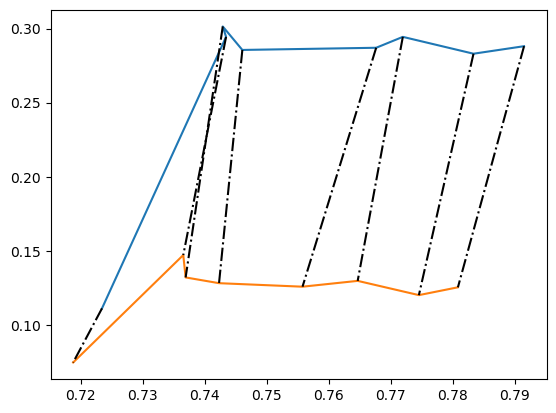

In [3]:
import matplotlib.pyplot as plt
for m in df.beta.unique():
    x = df[df.beta==m]['SR']
    y = df[df.beta==m]['Pair SR gini']
    plt.plot(x,y,label=m)
for m in df.model.unique():
    x = df[df.model==m]['SR']
    y = df[df.model==m]['Pair SR gini']
    plt.plot(x,y,'k-.', label=str(m) )

In [4]:
import plotly.express as px

In [8]:
fig = px.line(df, x="SR",y="Pair SR gini",color="beta", text='Day')
fig.update_traces(textposition="bottom left")
fig.show()